# Signal Processing 

This notebook documents the various denoising techniques used to process the ECG signals

Noise occurs in various forms in ECG signals mostly in the following forms as described in [Chatterjee et al](https://doi.org/10.1049/iet-spr.2020.0104)

<img src="./noise.png" style="width: 400px; height: auto;">

In [66]:
#required libraries
from wfdb.io import rdrecord
from wfdb import plot_items
from wfdb import Record
import wfdb.processing as wd
import pandas as pd
import matplotlib.pyplot as plt
import os
import pywt
import numpy as np
import ewtpy

In [67]:
# Base path to the directory containing all the records
base_path = "physionet.org/files/ecg-arrhythmia/1.0.0/WFDBRecords/01/010"
recordPath = []


for root, dirs, files in os.walk(base_path):

    files.sort()

    for file in files:
        if file.endswith(".mat"):

            record_name = os.path.splitext(file)[0]

            record_path = os.path.join(root, record_name)


            recordPath.append(record_path)



In [68]:
records:list[Record] = []
sf = 0
for r in recordPath:
    record = rdrecord(
r
    )
    if sf == 0:
        sf = record.fs
    elif sf != record.fs:
        raise ValueError("Sampling frequency of signals do not match")
    records.append(record)

In [69]:
#Normalisation of signals

for record in records:
    record.p_signal=wd.normalize_bound(record.p_signal)

In [70]:
#loading signal data to data frame for easy manipulation
signalsDf:list[pd.DataFrame]=[]
for s in records:
    signalsDf.append(s.to_dataframe())

In [71]:
#function to plot all signals 
def plotLeads(signal:pd.DataFrame,big=False):
    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    x=9 if not big else 16
    y=6 if not big else 12
    plt.figure(figsize=(x, y))


    for i, lead in enumerate(index):
        plt.subplot(4, 3, i + 1)  
        plt.plot(signal[lead][:300]) 
        plt.title(lead)           
        plt.grid(True)            


    plt.tight_layout()
    plt.show()

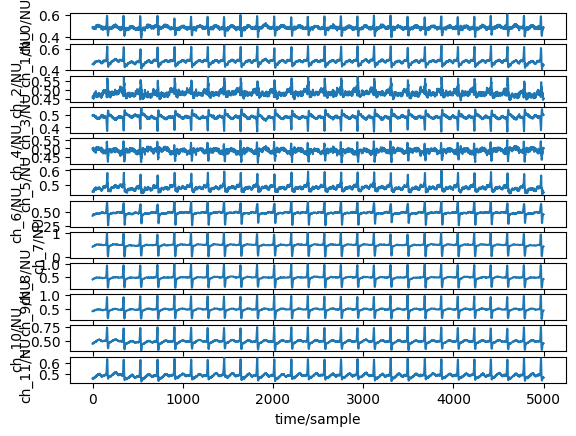

In [72]:
#outputting original signal
plot_items(signal=signalsDf[3].to_numpy())

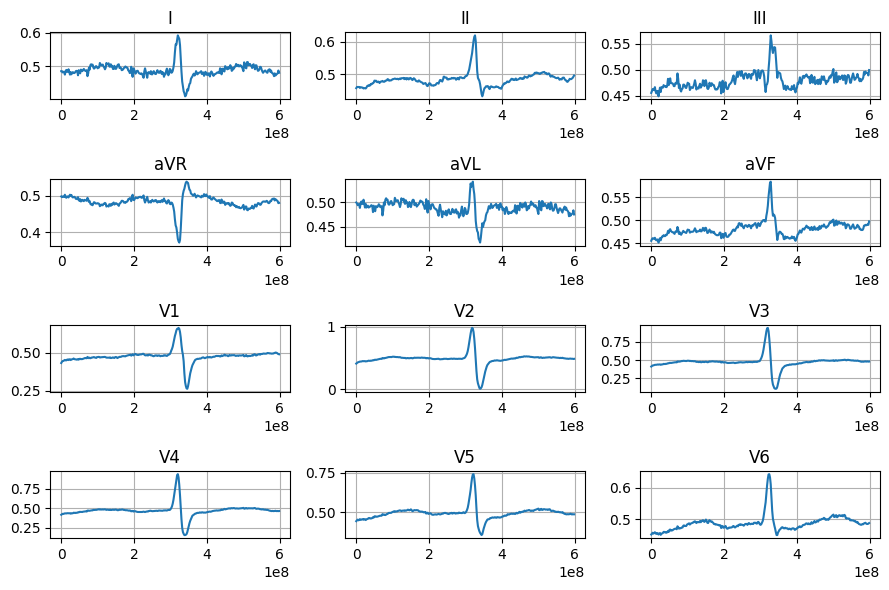

In [73]:
plotLeads(signalsDf[3])

## 1. Removing Wander

For removing baseline wander high pass filter is used, typically occurs as a low frequency, typically before 0.5Hz, litreature suggestes using HP filter at range 0.7-0.8 Hz is most effective for removing such wander. 

In [74]:
from scipy import signal

In [75]:
#using record 01/010/JS000001 for refrence
unProcessed= signalsDf[3]

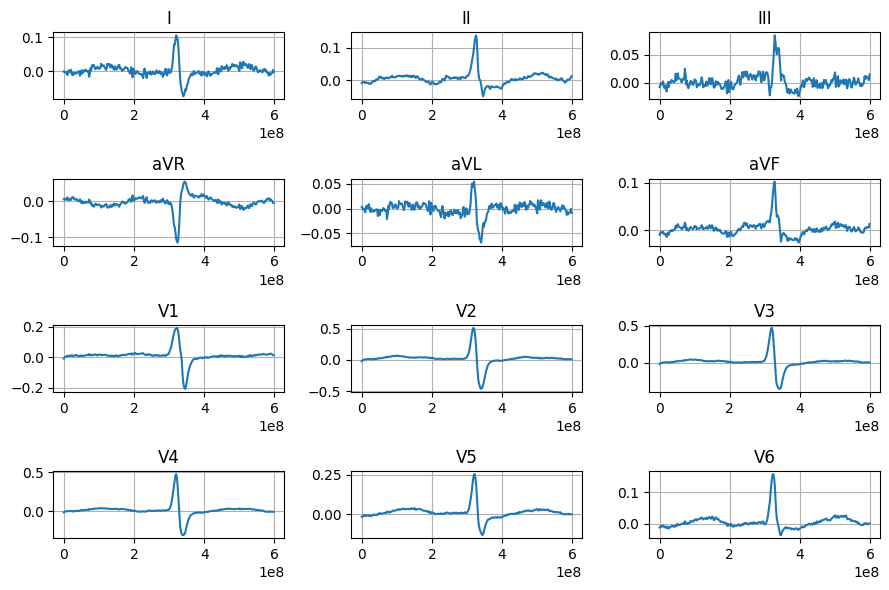

In [76]:
def removeBaselineWander(ecg_signal:pd.DataFrame,sf):
    sampling_rate = sf  
    cutoff_frequency = 0.8
    nyquist_rate = sampling_rate / 2

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 

    b, a = signal.butter(1, cutoff_frequency / nyquist_rate, btype='highpass')
    for i in index:    
        ecg_signal[i] = signal.filtfilt(b, a, ecg_signal[i])
    return ecg_signal

rbwSignal=pd.DataFrame(unProcessed)
rbwSignal=removeBaselineWander(rbwSignal,sf)

plotLeads(rbwSignal)


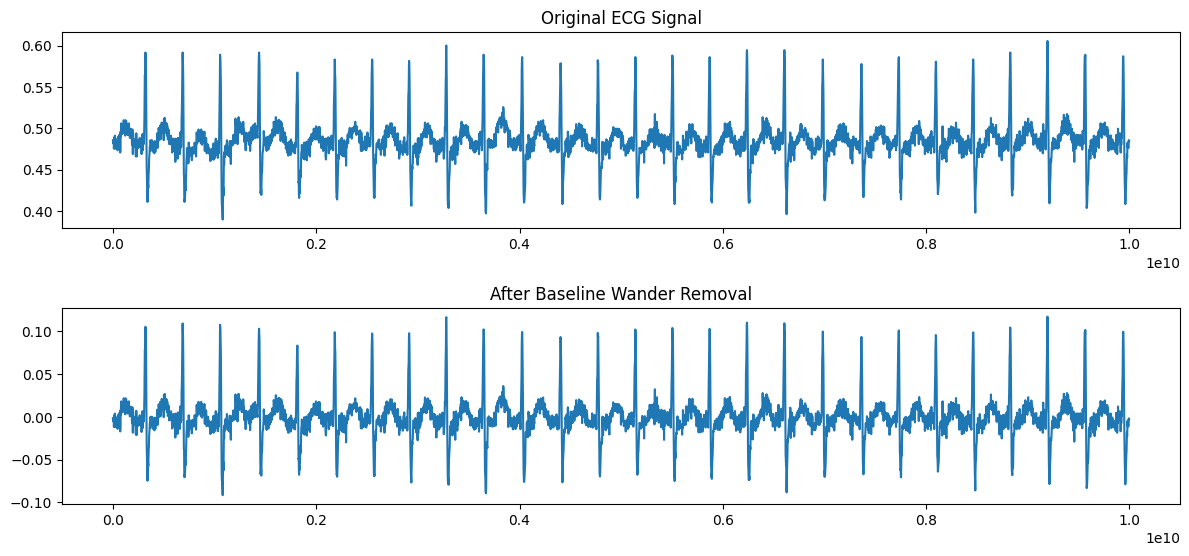

In [77]:
#for reference we will be plotting signal I
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title('Original ECG Signal')
plt.plot(unProcessed['I'])
plt.subplot(3, 1, 2)
plt.title('After Baseline Wander Removal')
plt.plot(rbwSignal['I'])
plt.tight_layout()
plt.show()

## 2. Remove constant noise

Signal has constant noise caused by powerline or random high frequencies in the wave can be removed by filter as they are not part of the ECG signal itself and do not interfere with the system. 

#### 2.1 White noise

This usually occurs in the high frequencies, ECG signals are relatively low frequency so noise can be removed using a low pass filter, many advanced techniques also exist to remove this type of noise, the best usually being deep learning models, our model most likely will not require such levels of noise removals. 

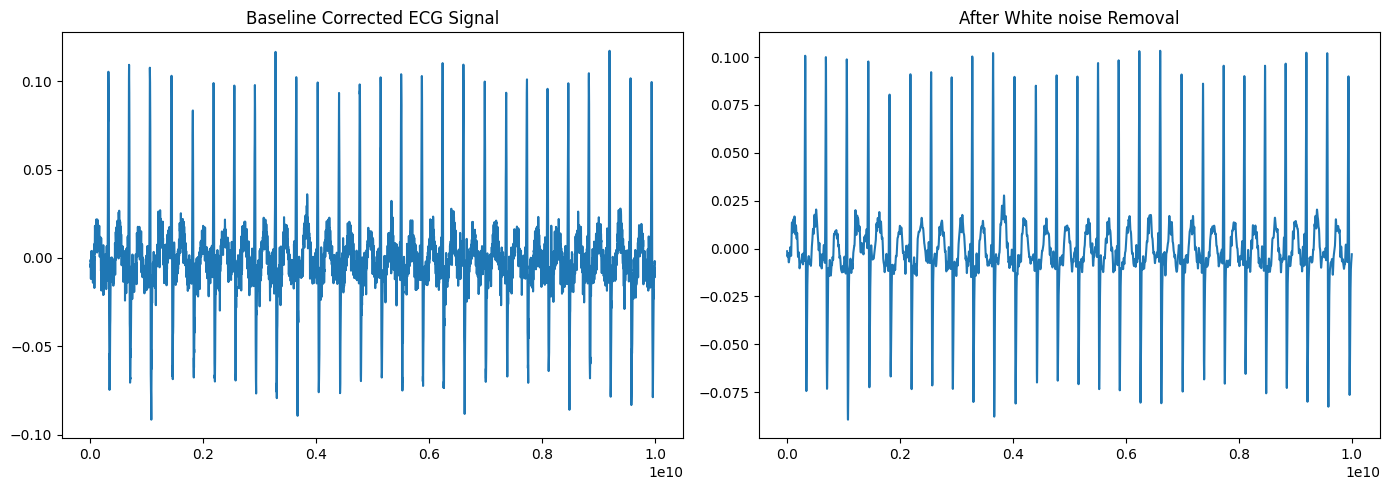

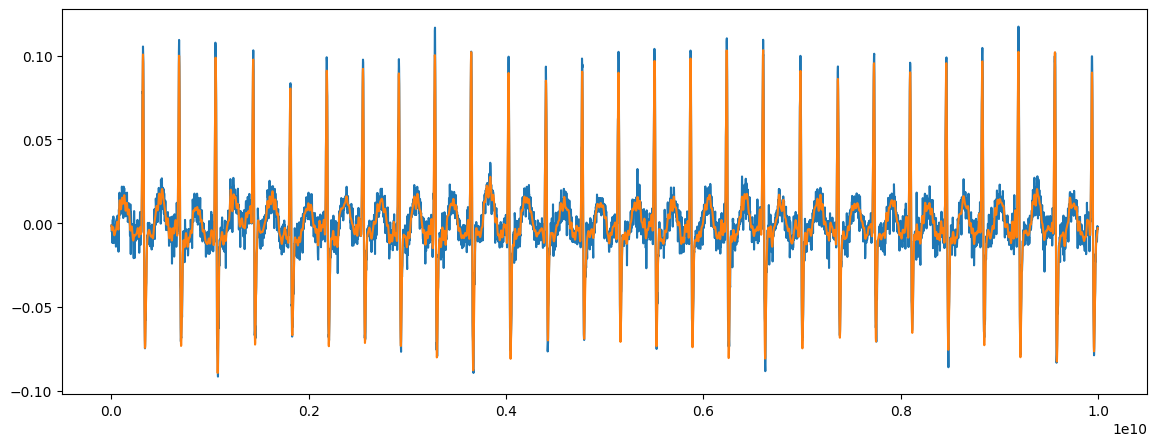

In [78]:
def removeHighFrequency(ecg_signal,sf):
    sampling_rate = sf  
    cutoff_frequency = 45
    nyquist_rate = sampling_rate / 2

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 

    b, a = signal.butter(4, cutoff_frequency / nyquist_rate, btype='lowpass')
    for i in index:    
        ecg_signal[i] = signal.filtfilt(b, a, ecg_signal[i])
    return ecg_signal


signal2_1=pd.DataFrame(rbwSignal)
signal2_1=removeHighFrequency(signal2_1,sf)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Baseline Corrected ECG Signal')
plt.plot(rbwSignal['I'])
plt.subplot(1, 2, 2)
plt.title('After White noise Removal')
plt.plot(signal2_1['I'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(rbwSignal['I'])
plt.plot(signal2_1['I'])
plt.show()




#### 2.2 Power line interference  

ECG monitors get powerline interference is present at ECG signal at around 50 Hz. Many ways are present to remove this noise one is basic notch filter for removal at that frequency. Stationary wavelet transformation is also found to be effective at removal of such noise.  

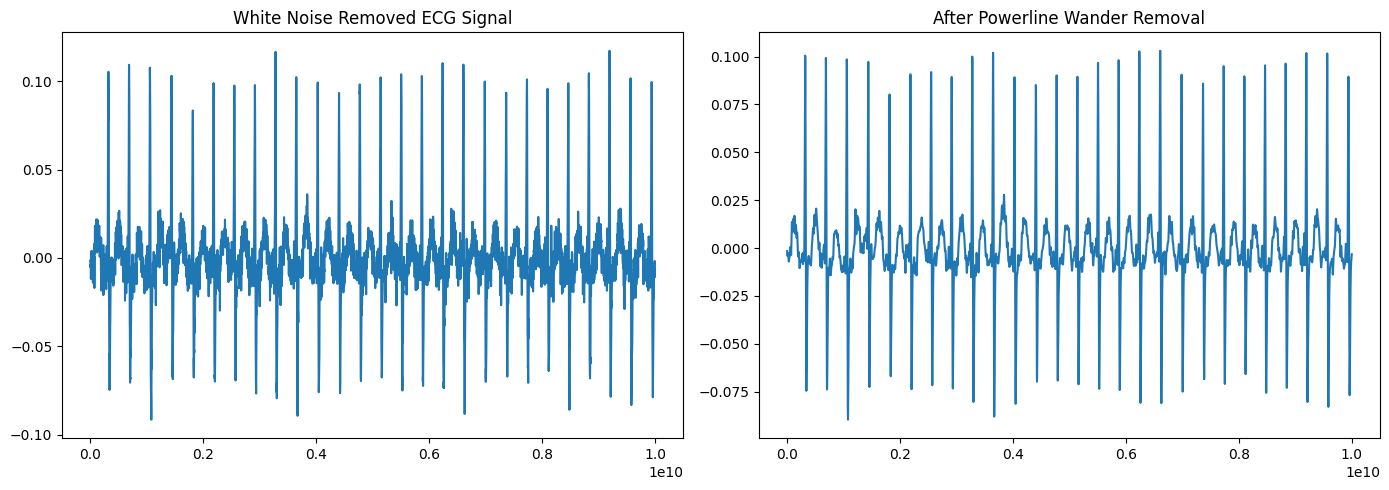

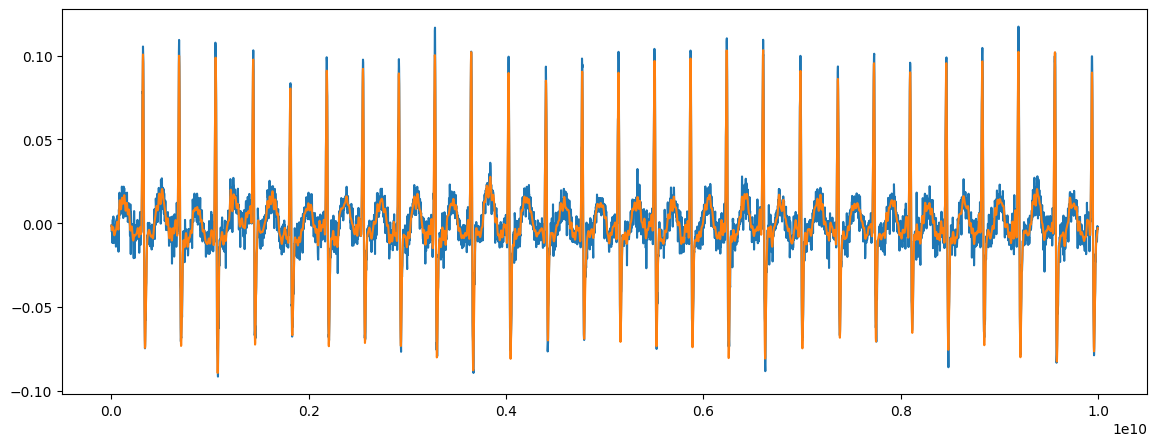

In [79]:
def notchFilter(ecg_signal, sf  ):
    notch_freq=50
    quality_factor=30
    sampling_rate =sf
    nyquist_rate = sampling_rate / 2

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    b, a = signal.iirnotch(notch_freq / nyquist_rate, quality_factor)
    for i in index:    
        ecg_signal[i] = signal.filtfilt(b, a, ecg_signal[i])
    return ecg_signal


signal2_2_1=pd.DataFrame(signal2_1)
signal2_2_1=notchFilter(signal2_2_1,sf)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('White Noise Removed ECG Signal')
plt.plot(rbwSignal['I'])
plt.subplot(1, 2, 2)
plt.title('After Powerline Wander Removal')
plt.plot(signal2_2_1['I'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(rbwSignal['I'])
plt.plot(signal2_1['I'])
plt.show()

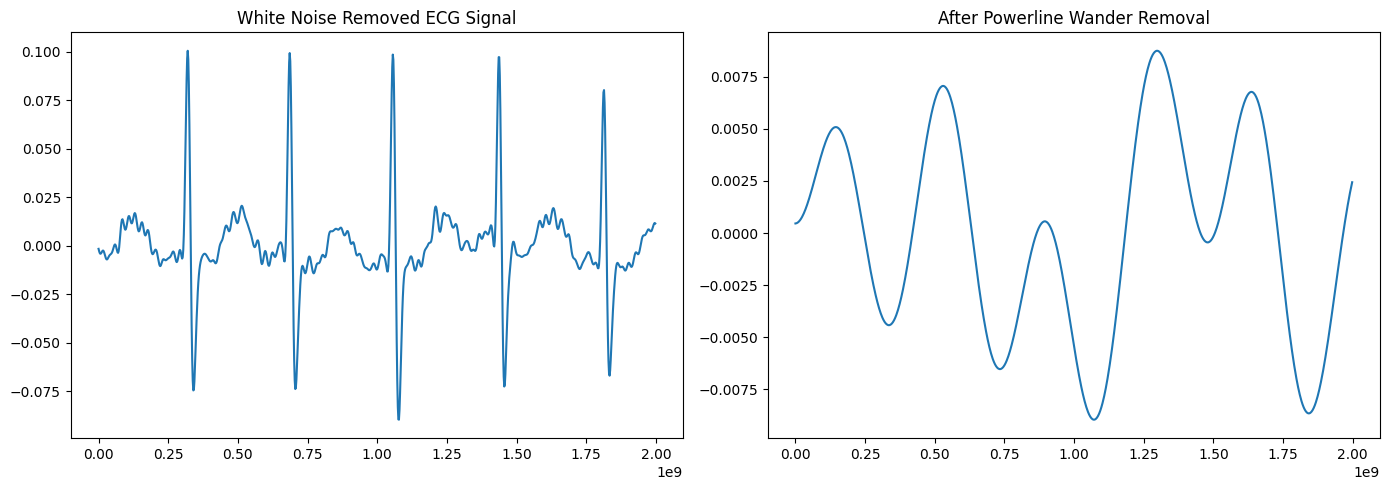

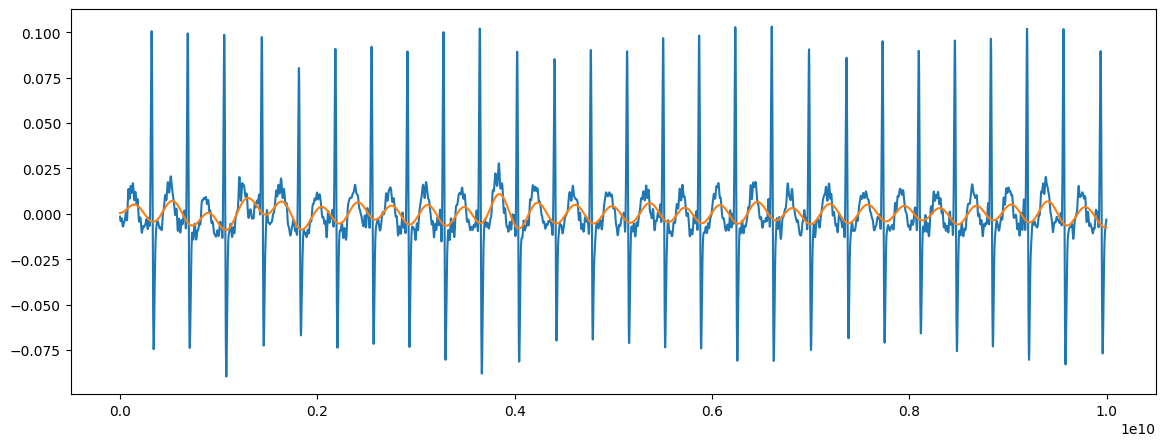

In [80]:
#EWT

def EWT(ecg_signal, sf  ):
   
    sampling_rate =sf
    nyquist_rate = sampling_rate / 2

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
   
    for i in index:    
        ecg_signal[i],_,_ = ewtpy.EWT1D(ecg_signal[i],N=2,log=0, sigmaFilter=1.0774299557703921*10**-5, lengthFilter=1, completion=1, reg='locmin')
    return ecg_signal


signal2_2_2=pd.DataFrame(signal2_1)
signal2_2_2=EWT(signal2_2_2,sf)



plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('White Noise Removed ECG Signal')
plt.plot(signal2_2_1['I'][:1000])
plt.subplot(1, 2, 2)
plt.title('After Powerline Wander Removal')
plt.plot(signal2_2_2['I'][:1000])
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(signal2_2_1['I'])
plt.plot(signal2_2_2['I'])
plt.show()

## 3 Random Noise

Random noise is fond in the frequency range of teh ECG signals, wavelet reductions are shown to be effective in removal of such noise, db6 and Sym6 seem to outperform other forms of DWT



In [81]:
#db6 DWT
def DWT(ecg_signal, wavelet,level):
   

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    for i in index:
        coeffs = pywt.wavedec(ecg_signal[i], wavelet, level=level)

        sigma = np.median(np.abs(coeffs[-1])) / 0.6745

        uthresh = sigma * np.sqrt(2 * np.log(len(ecg_signal[i])))
        

        denoised_coeffs = [pywt.threshold(c, uthresh, mode='soft') for c in coeffs]
        

        ecg_signal[i] = pywt.waverec(denoised_coeffs, wavelet)
    
    return ecg_signal


signal3_1=pd.DataFrame(signal2_2_1)
signal3_2=pd.DataFrame(signal2_2_1)

signal3_1=DWT(signal3_1,'db6',6)
signal3_2=DWT(signal3_2,'sym6',6)



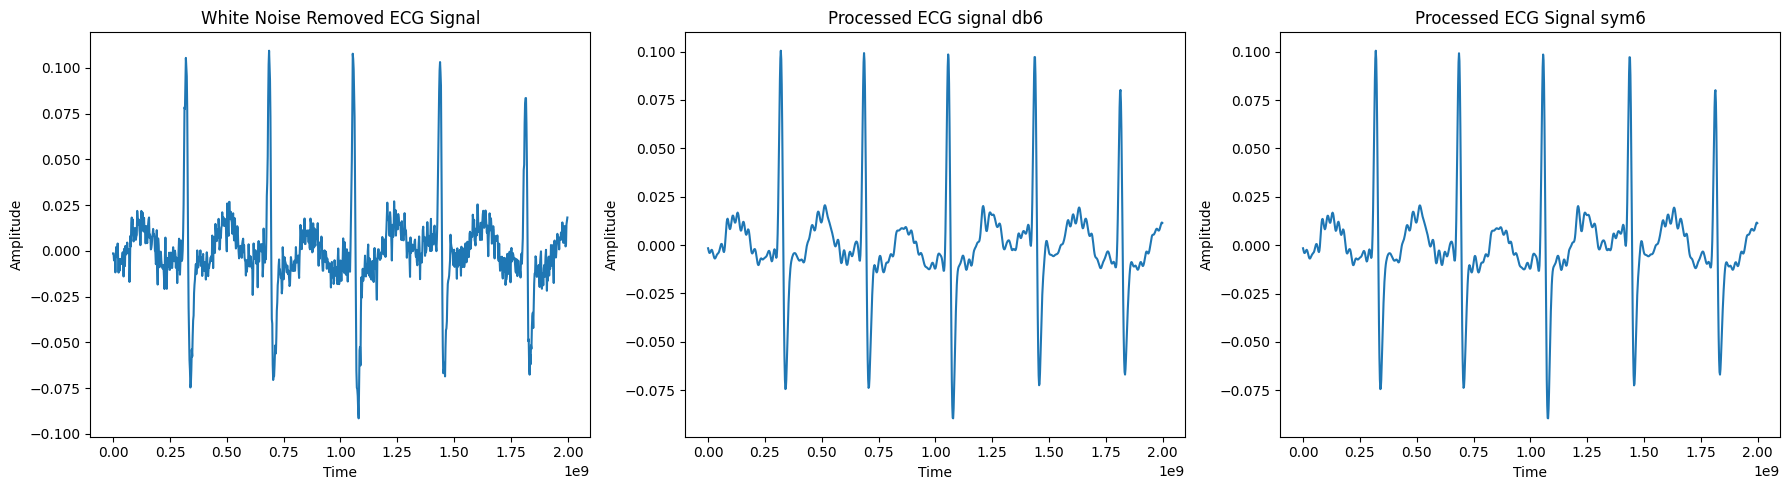

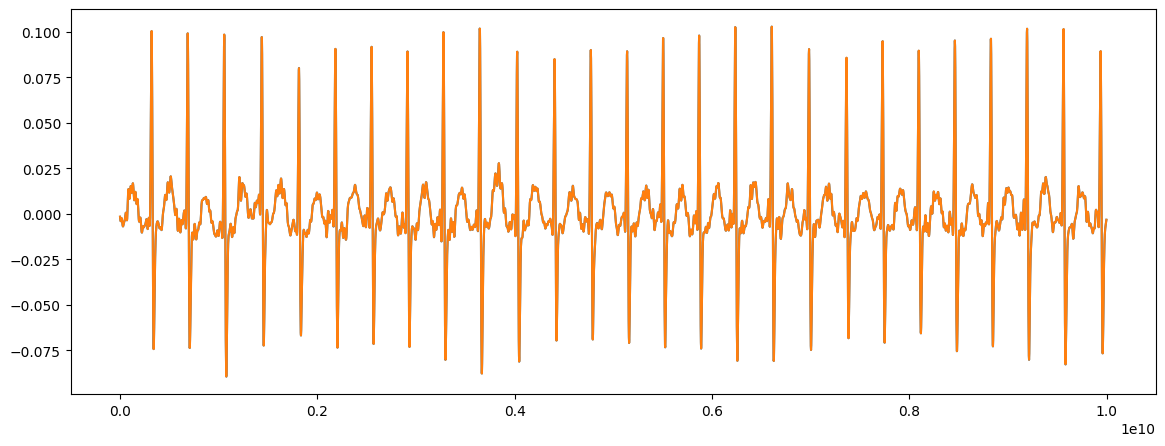

In [82]:


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plt.title('White Noise Removed ECG Signal')
plt.plot(rbwSignal['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.subplot(1, 3, 2)
plt.title('Processed ECG signal db6')
plt.plot(signal3_1['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.subplot(1, 3, 3)
plt.title('Processed ECG Signal sym6')
plt.plot(signal3_2['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()


plt.show()
plt.figure(figsize=(14,5))
plt.plot(signal3_1['I'])
plt.plot(signal3_2['I'])
plt.show()

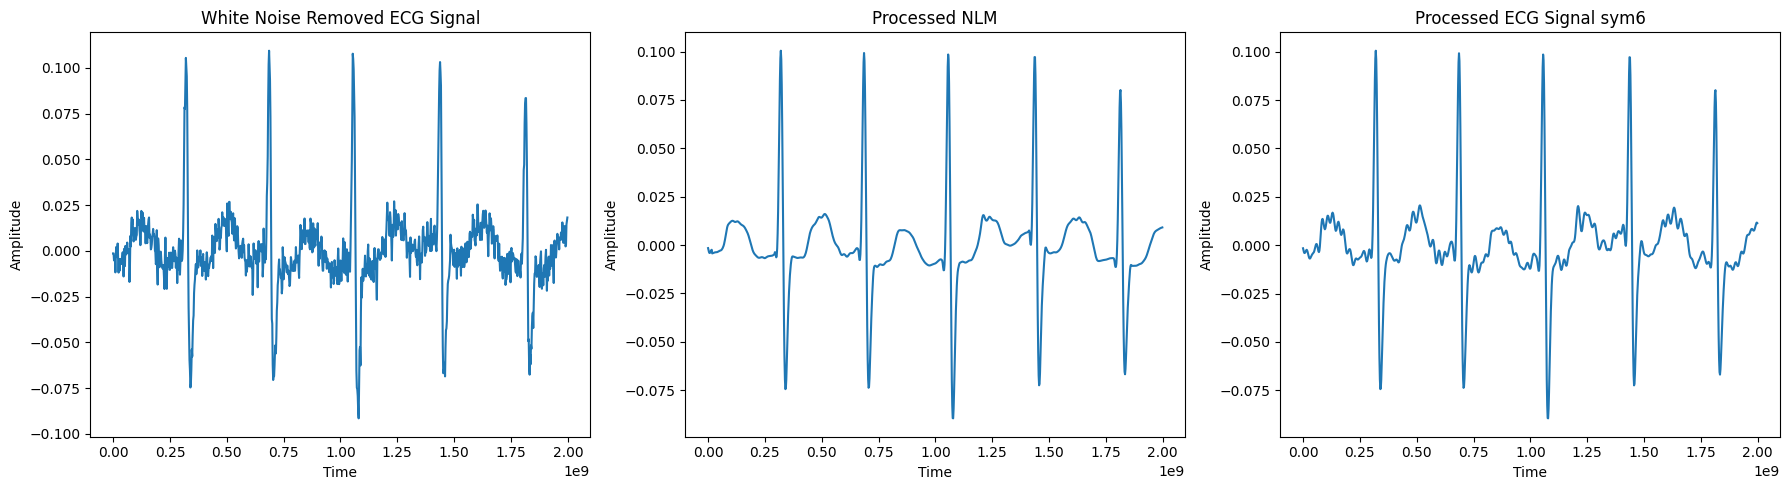

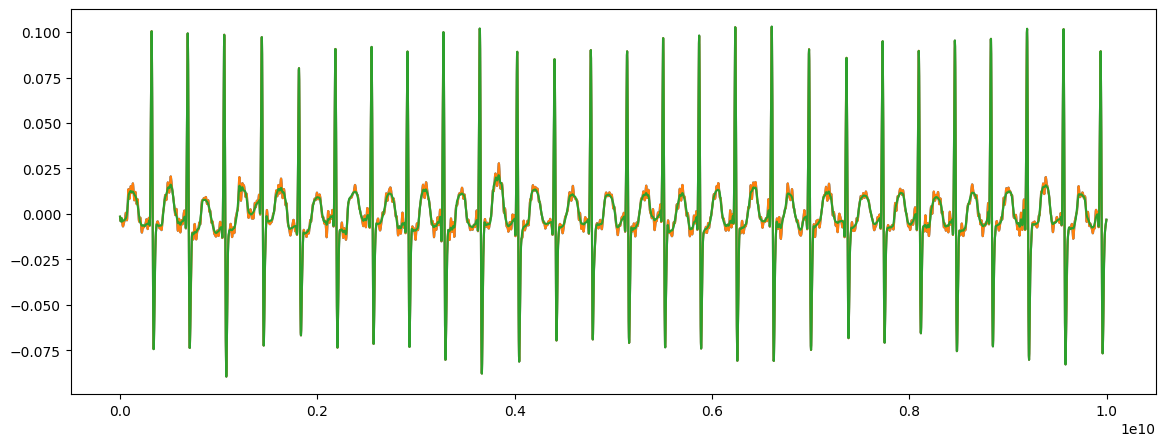

In [83]:
from NLM_1dDarbon import NLM_1dDarbon

def NLM(ecg_signal):
    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    for i in index:
        

        ecg_signal[i] = NLM_1dDarbon(ecg_signal[i],P=18,PatchHW=8,Nvar=0.005)
    
    return ecg_signal



signal3_3=pd.DataFrame(signal2_2_1)
signal3_3=NLM(signal3_3)

plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plt.title('White Noise Removed ECG Signal')
plt.plot(rbwSignal['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.subplot(1, 3, 2)
plt.title('Processed NLM')
plt.plot(signal3_3['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.subplot(1, 3, 3)
plt.title('Processed ECG Signal sym6')
plt.plot(signal3_2['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()


plt.show()
plt.figure(figsize=(14,5))
plt.plot(signal3_1['I'])
plt.plot(signal3_2['I'])
plt.plot(signal3_3['I'])
plt.show()

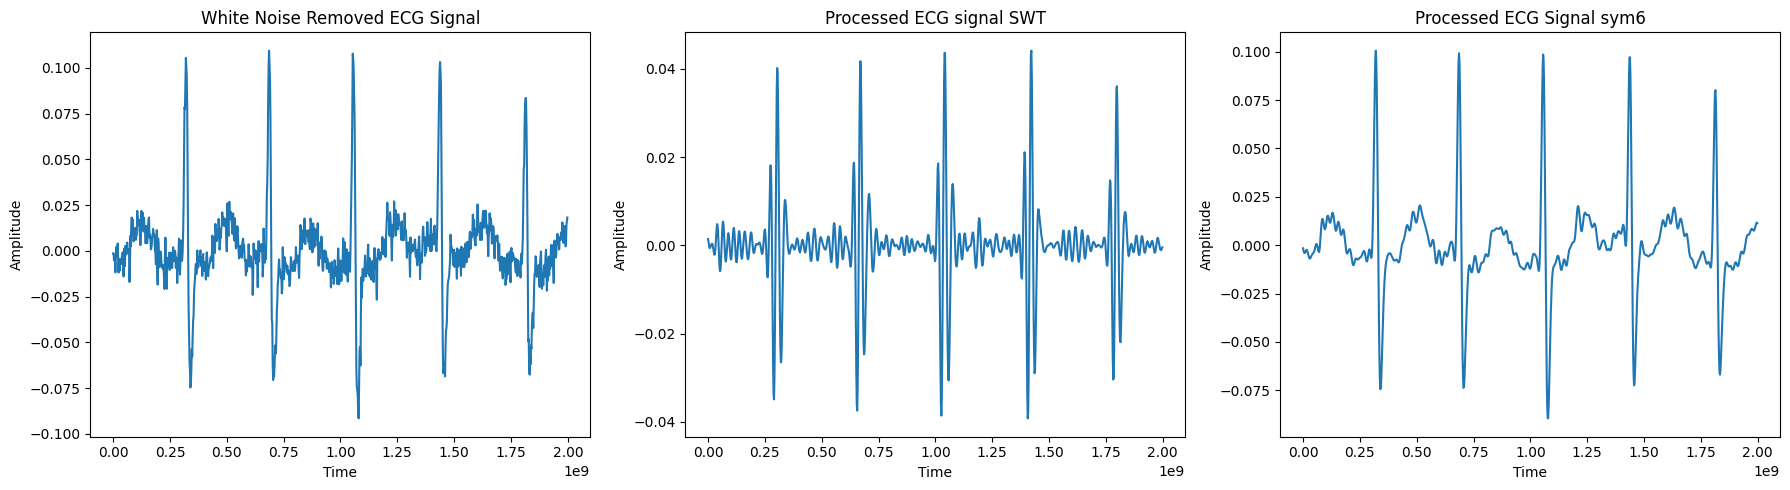

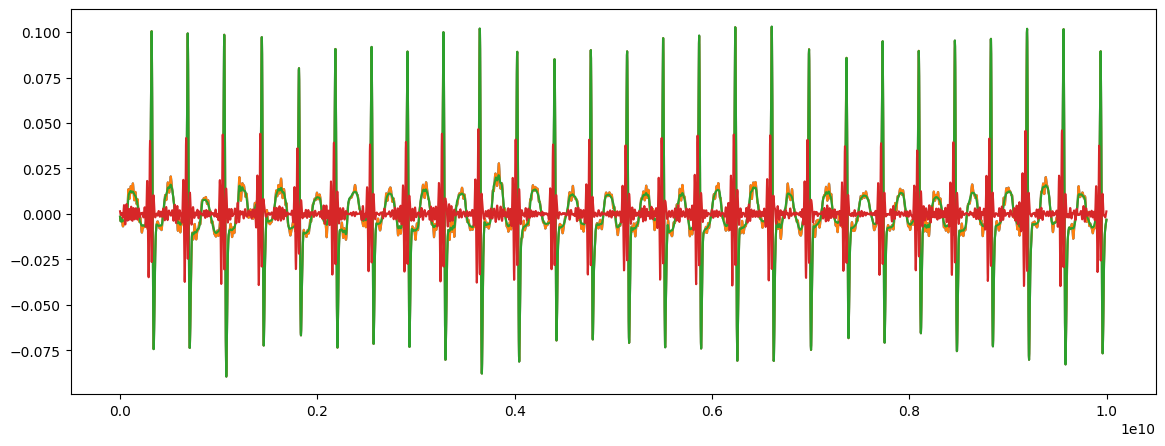

In [107]:
#
def SWT(ecg_signal, wavelet,level):
   

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    for i in index:
        coeffs = pywt.swt(ecg_signal[i], wavelet, level=level)

        sigma = np.median(np.abs(coeffs[-1])) / 0.6745

        uthresh = sigma * np.sqrt(2 * np.log(len(ecg_signal[i])))
        

        denoised_coeffs = [pywt.threshold(c, uthresh, mode='soft') for c in coeffs]
        

        ecg = pywt.iswt(denoised_coeffs, wavelet)
        ecg_signal[i]=ecg[0].T




    
    return ecg_signal


signal3_4=pd.DataFrame(signal2_2_1)
signal3_4=SWT(signal3_4,wavelet='db6',level=3)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plt.title('White Noise Removed ECG Signal')
plt.plot(rbwSignal['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.subplot(1, 3, 2)
plt.title('Processed ECG signal SWT')
plt.plot(signal3_4['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.subplot(1, 3, 3)
plt.title('Processed ECG Signal sym6')
plt.plot(signal3_2['I'][:1000])
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()


plt.show()
plt.figure(figsize=(14,5))
plt.plot(signal3_1['I'])
plt.plot(signal3_2['I'])
plt.plot(signal3_3['I'])
plt.plot(signal3_4["I"])
plt.show()

In [85]:
signal3_5=pd.DataFrame(rbwSignal)
signal3_6=pd.DataFrame(signal2_1)


signal3_5=SWT(signal3_5,wavelet='bior4.4',level=3)
signal3_6=DWT(signal3_6,wavelet='sym6',level=6)
signal3_7=pd.DataFrame(signal3_6)

signal3_7=SWT(signal3_7,wavelet='bior4.4',level=3)



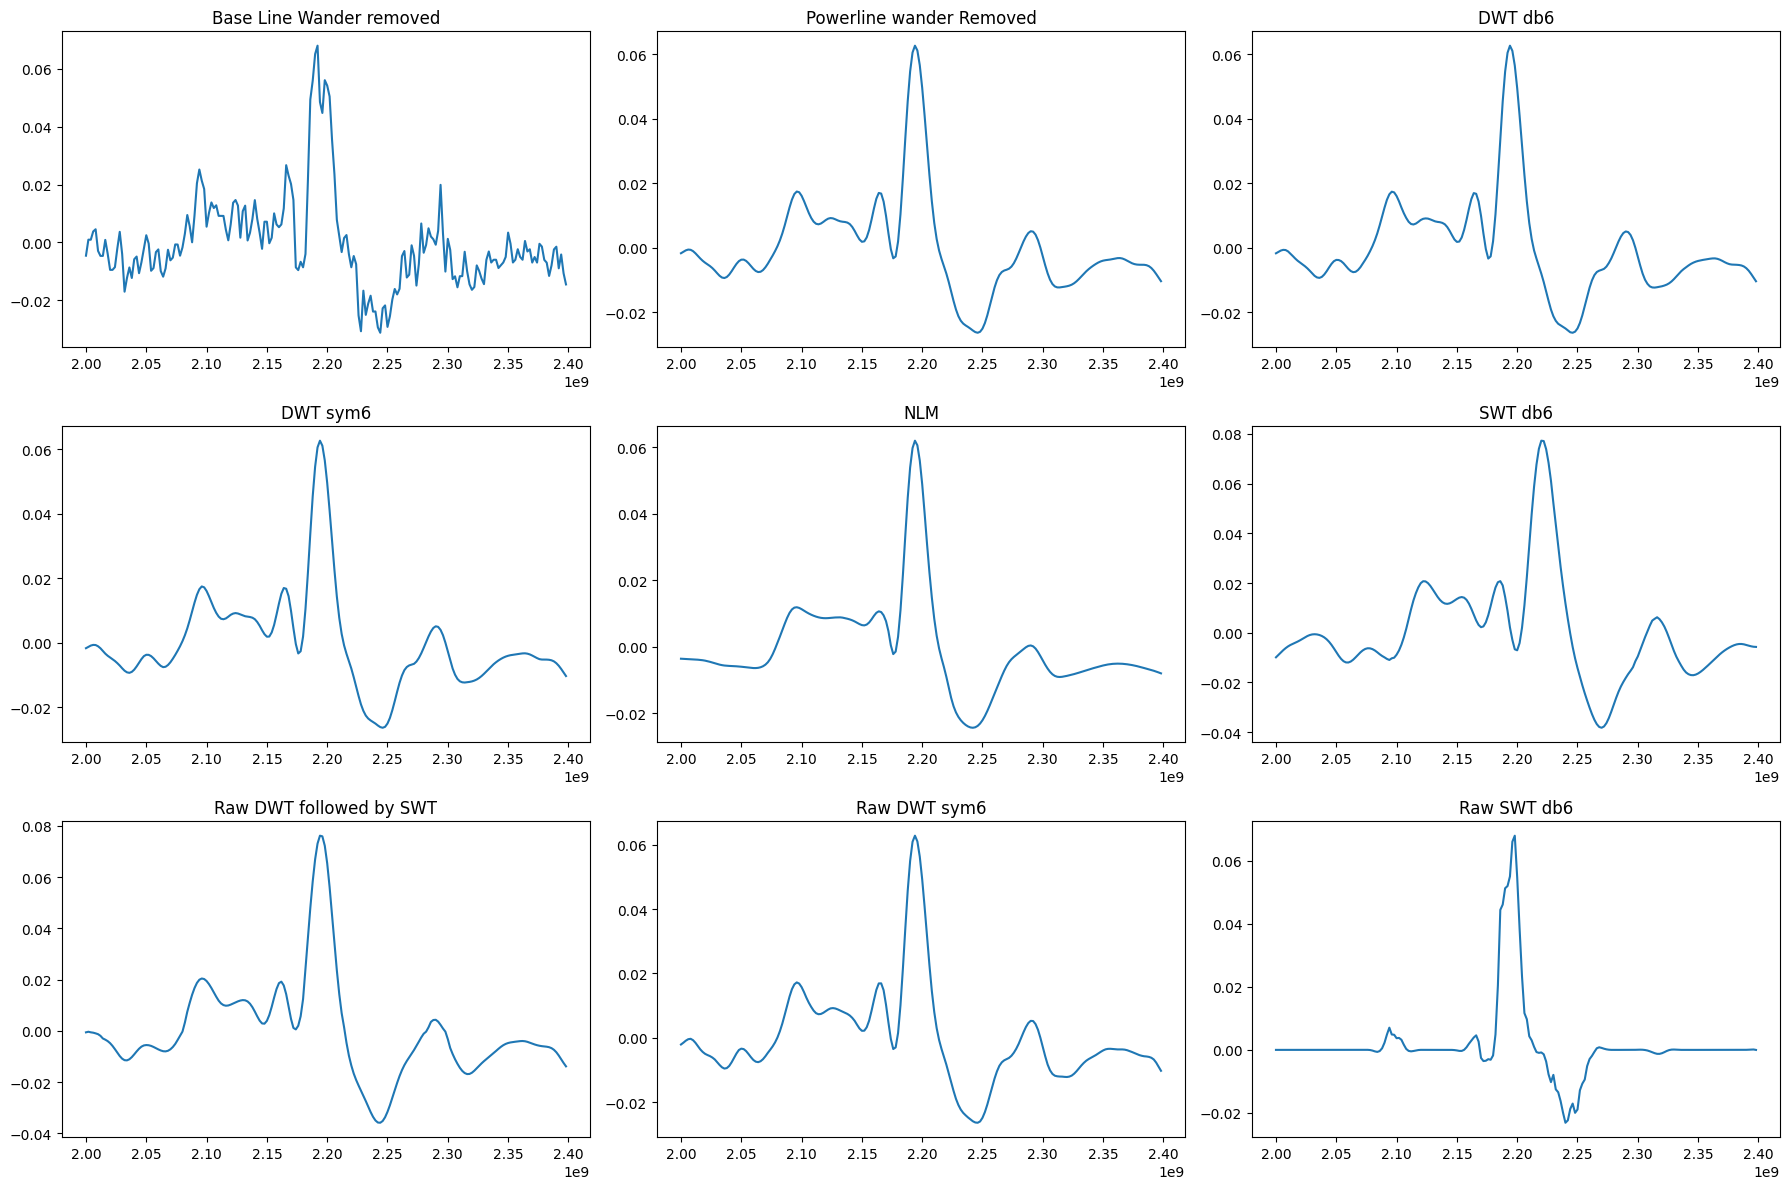

In [86]:


fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes[0, 0].plot(rbwSignal['III'][1000:1200])
axes[0, 0].set_title('Base Line Wander removed')

axes[0, 1].plot(signal2_2_1['III'][1000:1200])
axes[0, 1].set_title('Powerline wander Removed')

axes[0, 2].plot(signal3_1['III'][1000:1200])
axes[0, 2].set_title('DWT db6')

axes[1, 0].plot(signal3_2['III'][1000:1200])
axes[1, 0].set_title('DWT sym6')

axes[1, 1].plot(signal3_3['III'][1000:1200])
axes[1, 1].set_title('NLM')

axes[1, 2].plot(signal3_4['III'][1000:1200])
axes[1, 2].set_title('SWT db6')

axes[2, 2].plot(signal3_5['III'][1000:1200])
axes[2, 2].set_title('Raw SWT db6')

axes[2, 1].plot(signal3_6['III'][1000:1200])
axes[2, 1].set_title('Raw DWT sym6')

axes[2, 0].plot(signal3_7['III'][1000:1200])
axes[2, 0].set_title('Raw DWT followed by SWT')





plt.tight_layout()
plt.show()


In [87]:

def calculate_rmse(original_signal, denoised_signal):
    return np.sqrt(np.mean((np.array(original_signal) - np.array(denoised_signal))**2))

def calculate_prd(original_signal, denoised_signal):
    rmse = np.sqrt(np.mean((np.array(original_signal) - np.array(denoised_signal))**2))
    energy_original = np.sqrt(np.sum(np.array(original_signal)**2))
    return (rmse / energy_original) * 100

def calculate_snr(signal):
    signal = np.array(signal)
    signal_power = np.sum(signal**2)
    noise_power = np.mean((signal - np.mean(signal))**2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_snrimp(original_signal, denoised_signal):
    snr_in = calculate_snr(original_signal)
    snr_out = calculate_snr(denoised_signal)
    return snr_out - snr_in

In [88]:
rmse,snr,prd=[],[],[]
for i in [signal3_1,signal3_2,signal3_3,signal3_3,signal3_4,signal3_5,signal3_6,signal3_7]:
    rmse.append(calculate_rmse(rbwSignal['I'],i['I']))
    snr.append(calculate_snrimp(rbwSignal['I'],i['I']))
    prd.append(calculate_prd(rbwSignal['I'],i['I']))


In [89]:


leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
signals = [signal3_1, signal3_2, signal3_3, signal3_4, signal3_5, signal3_6, signal3_7]


results = []
for lead in leads:
    for x, i in enumerate(signals):
    
        rmse = calculate_rmse(unProcessed[lead], i[lead])
        snr = calculate_snrimp(unProcessed[lead], i[lead])
        prd = calculate_prd(unProcessed[lead], i[lead])
        
        # Append each calculation result as a new row in the DataFrame
        results.append({
            'Index': f"Signal{x+1}",
            'Lead': lead,
            'RMSE': rmse,
            'SNR': snr,
            'PRD%': prd
        })


results = pd.DataFrame(results)



In [90]:
r=results.groupby('Index').agg({
    'RMSE': ['mean', 'count'],
    'SNR': ['mean', 'count'],
    'PRD%': ['mean', 'count']
})
r





RMSE              SNR            PRD%      
             mean count       mean count      mean count
Index                                                   
Signal1  0.483244    12 -21.754756    12  1.399840    12
Signal2  0.483245    12 -21.754758    12  1.399842    12
Signal3  0.483249    12 -21.754899    12  1.399854    12
Signal4  0.500073    12 -21.754392    12  1.447864    12
Signal5  0.483863    12 -21.734345    12  1.401576    12
Signal6  0.483242    12 -21.754759    12  1.399833    12
Signal7  0.483675    12 -21.753773    12  1.401056    12

<Axes: xlabel='Index'>

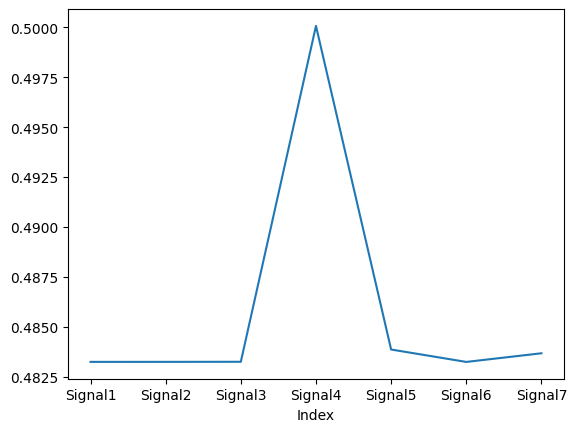

In [91]:
r['RMSE']['mean'].plot()

<Axes: xlabel='Index'>

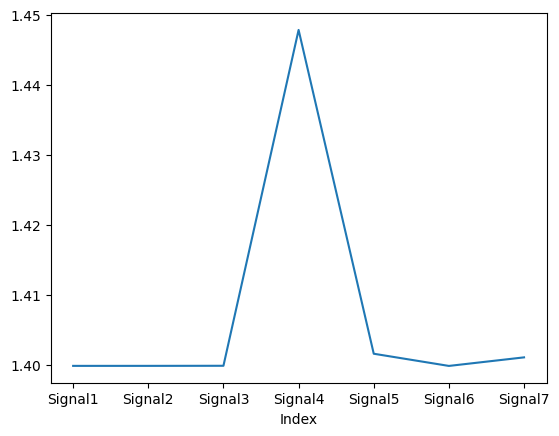

In [92]:
r['PRD%']['mean'].plot()

<Axes: xlabel='Index'>

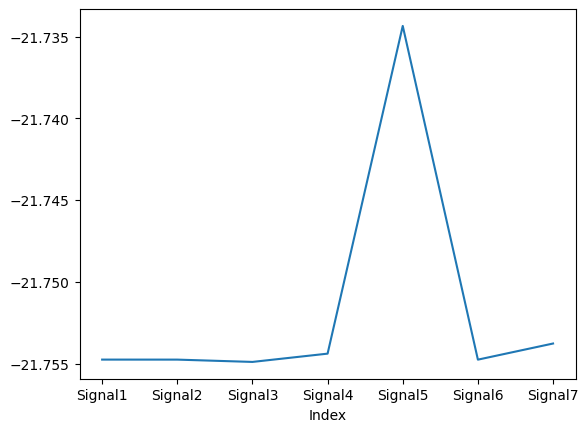

In [93]:
r['SNR']['mean'].plot()

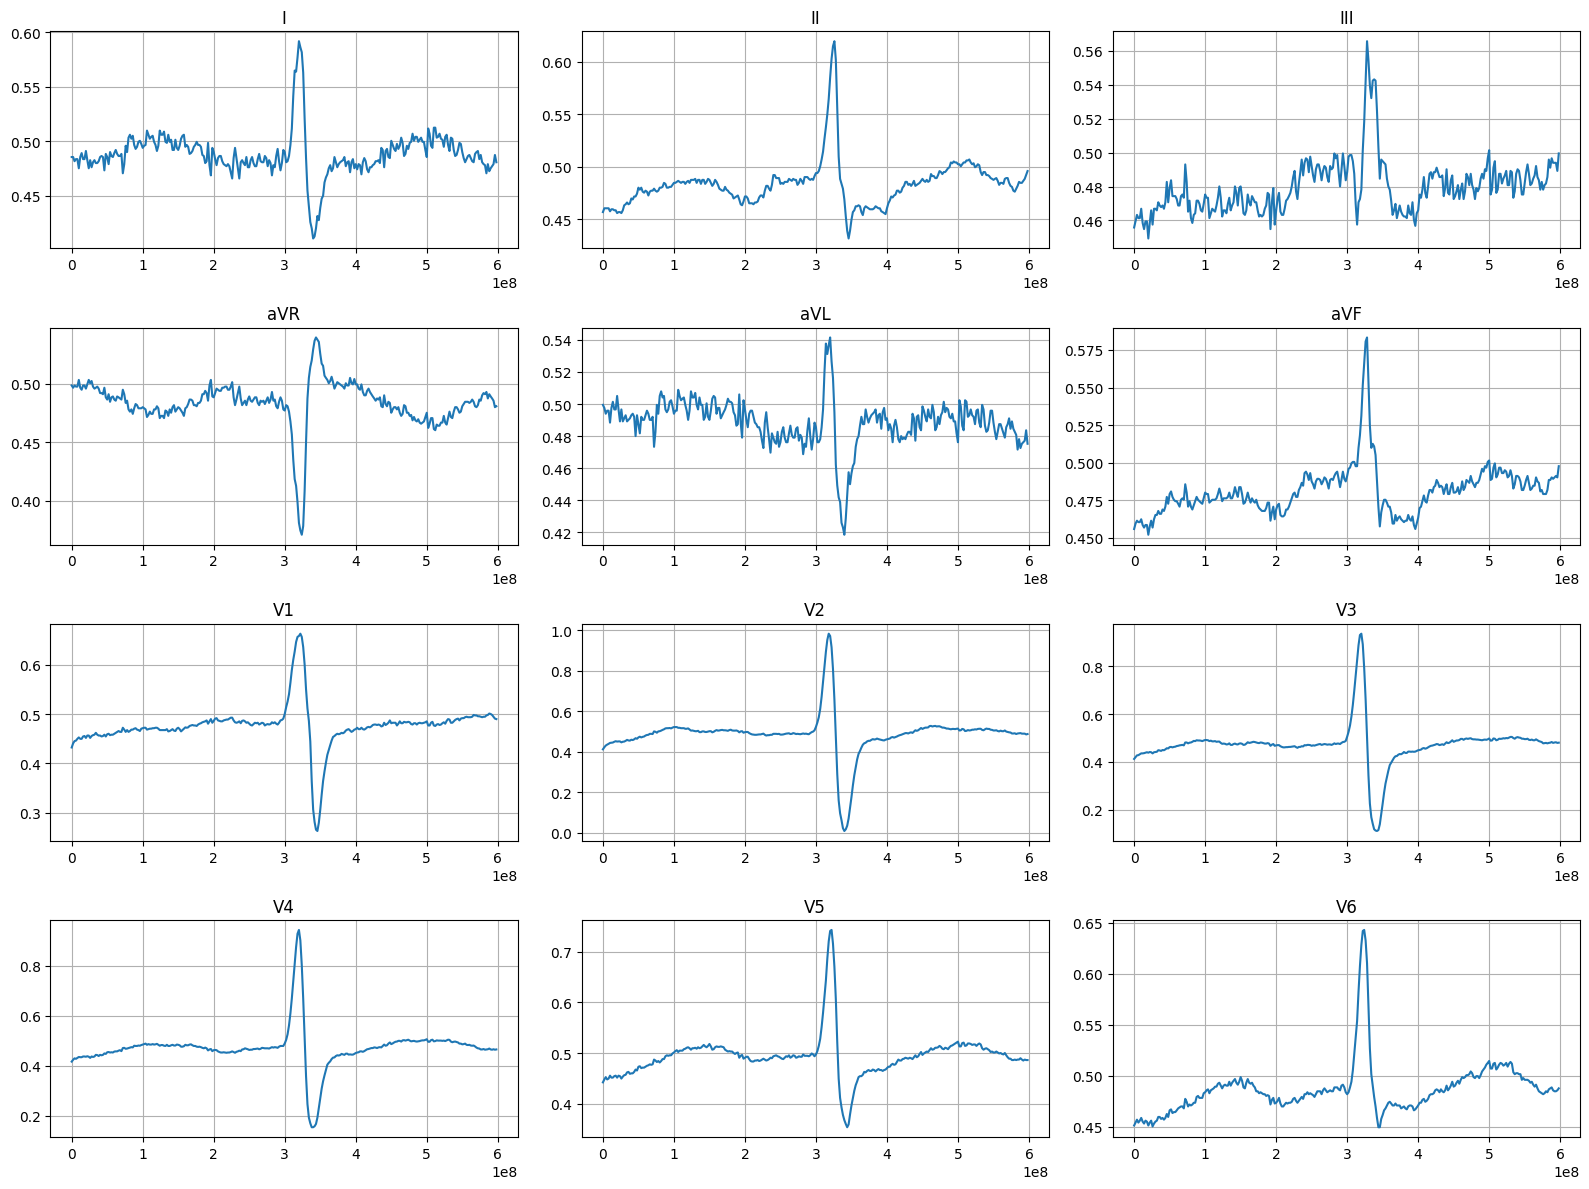

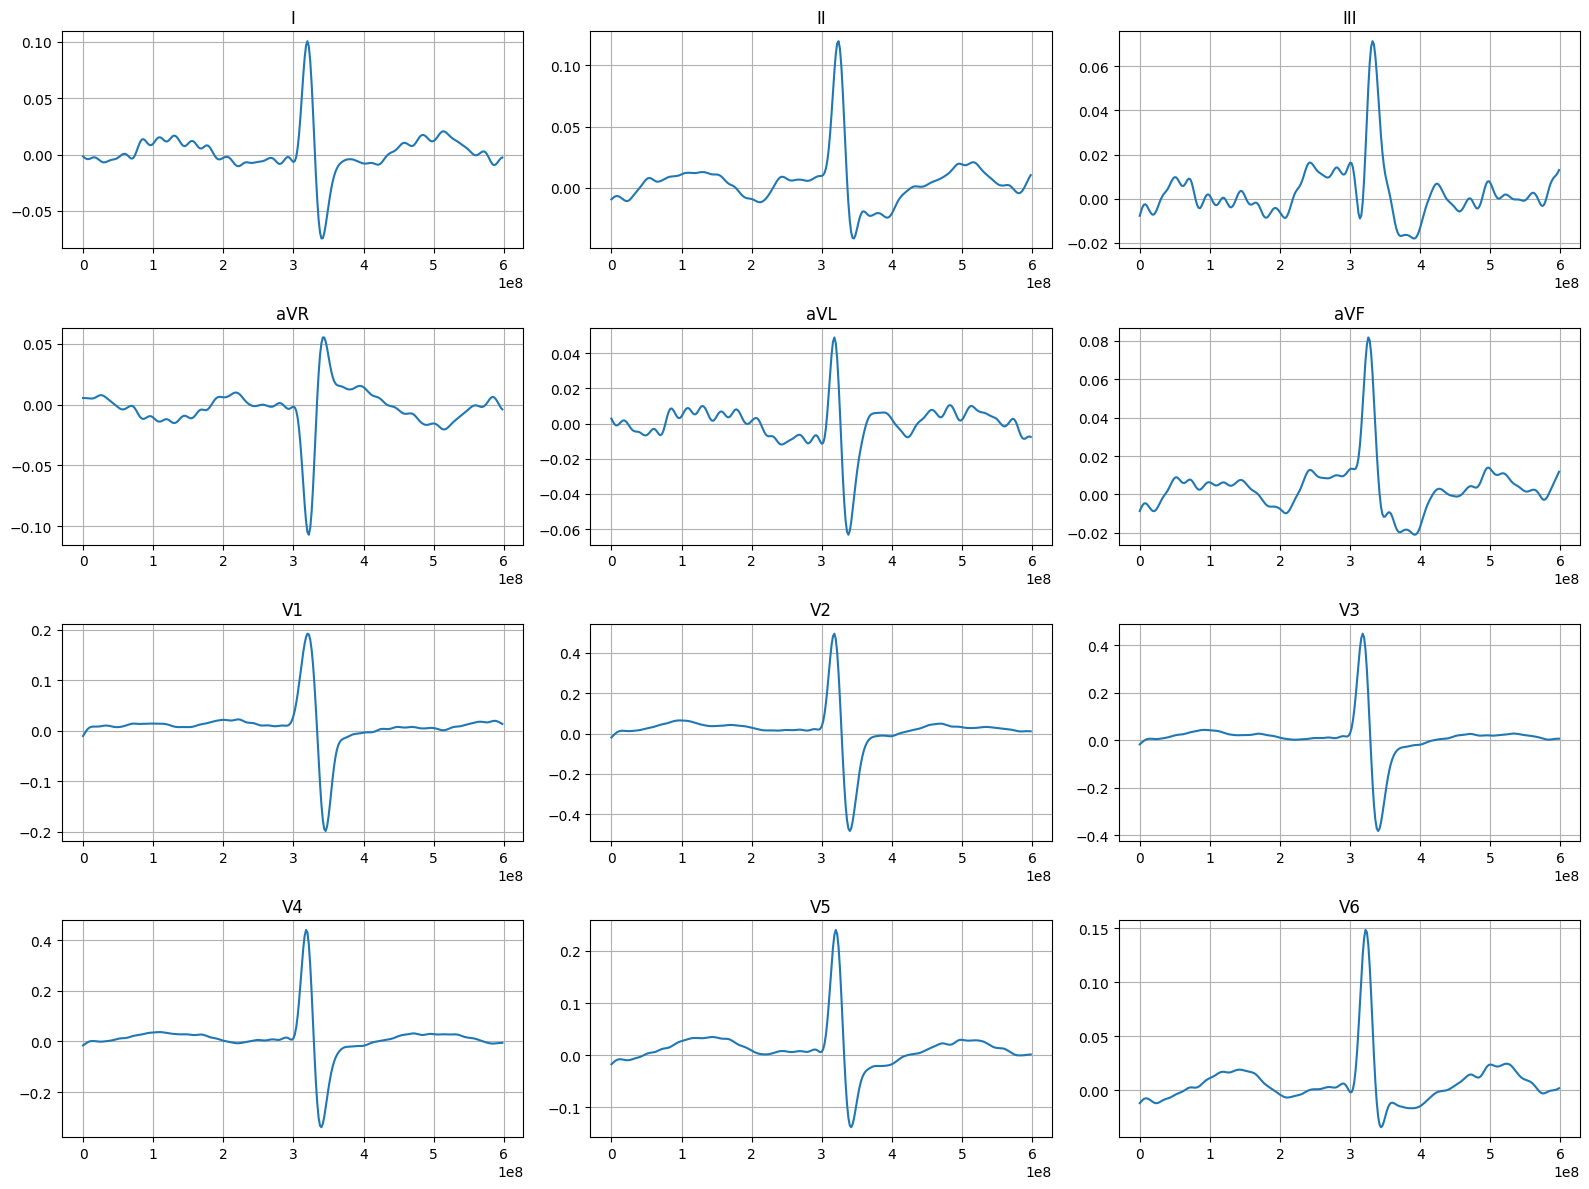

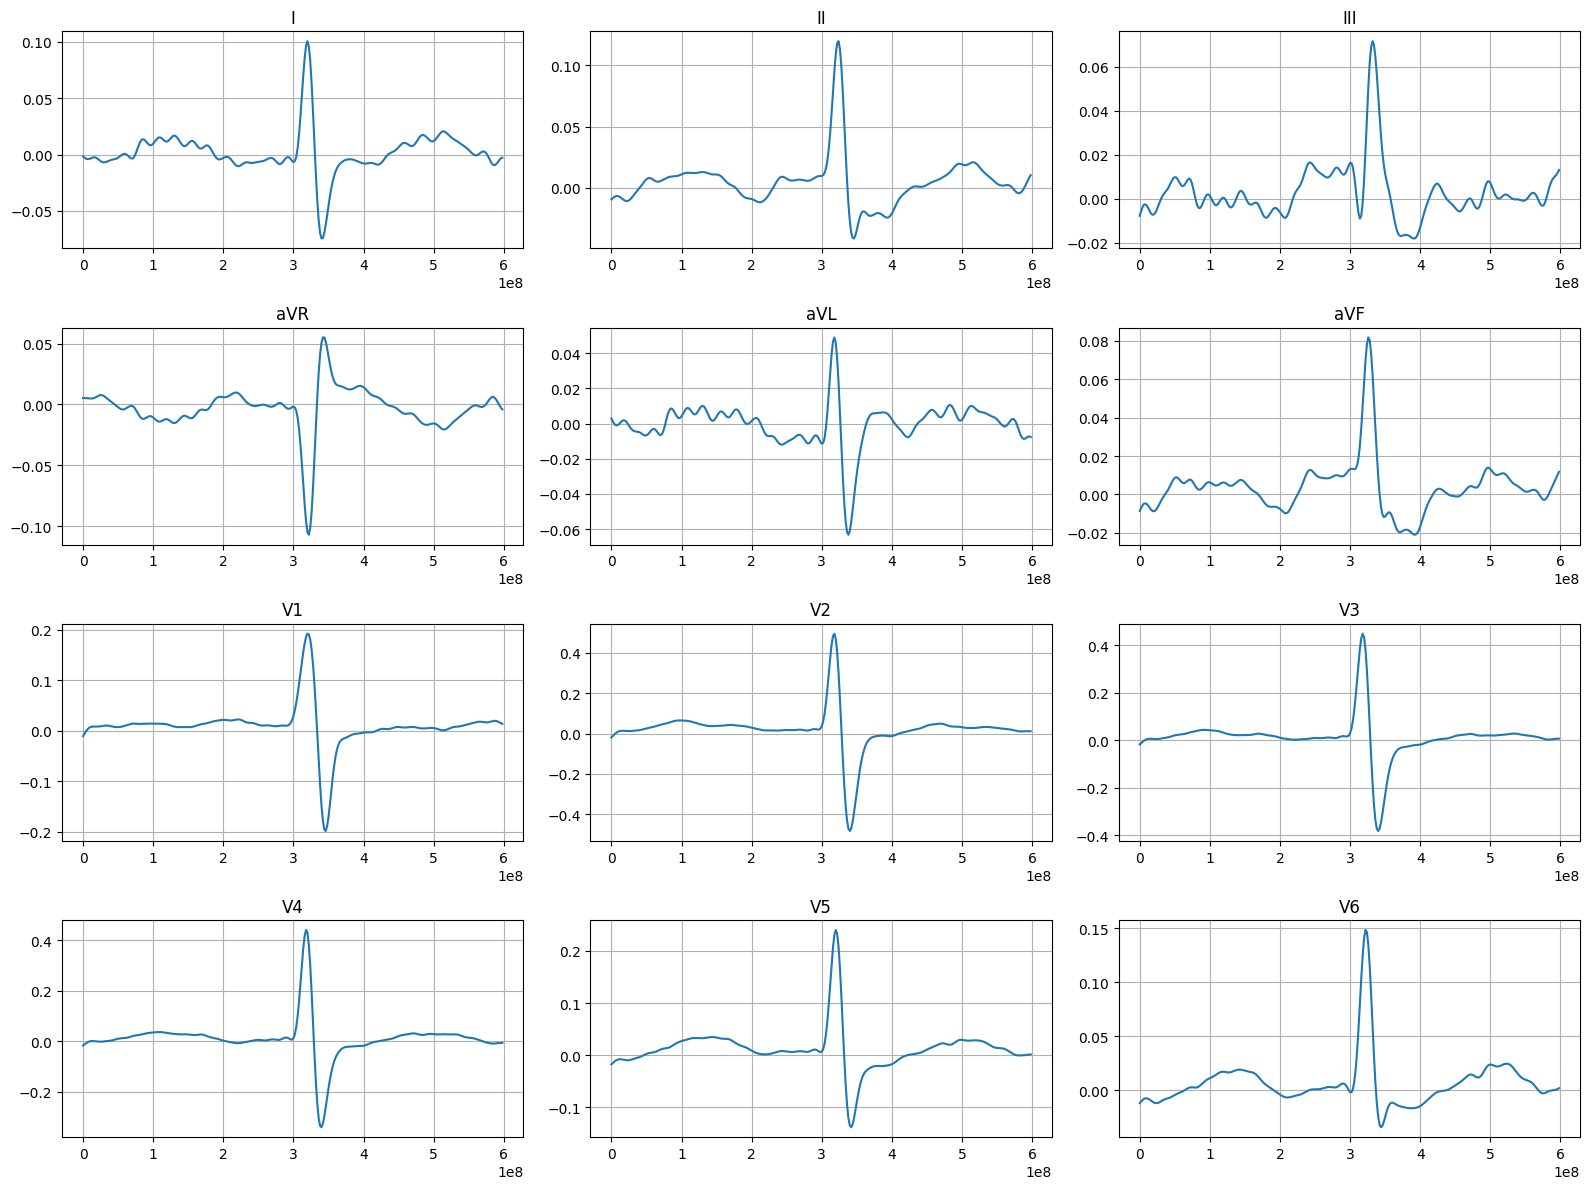

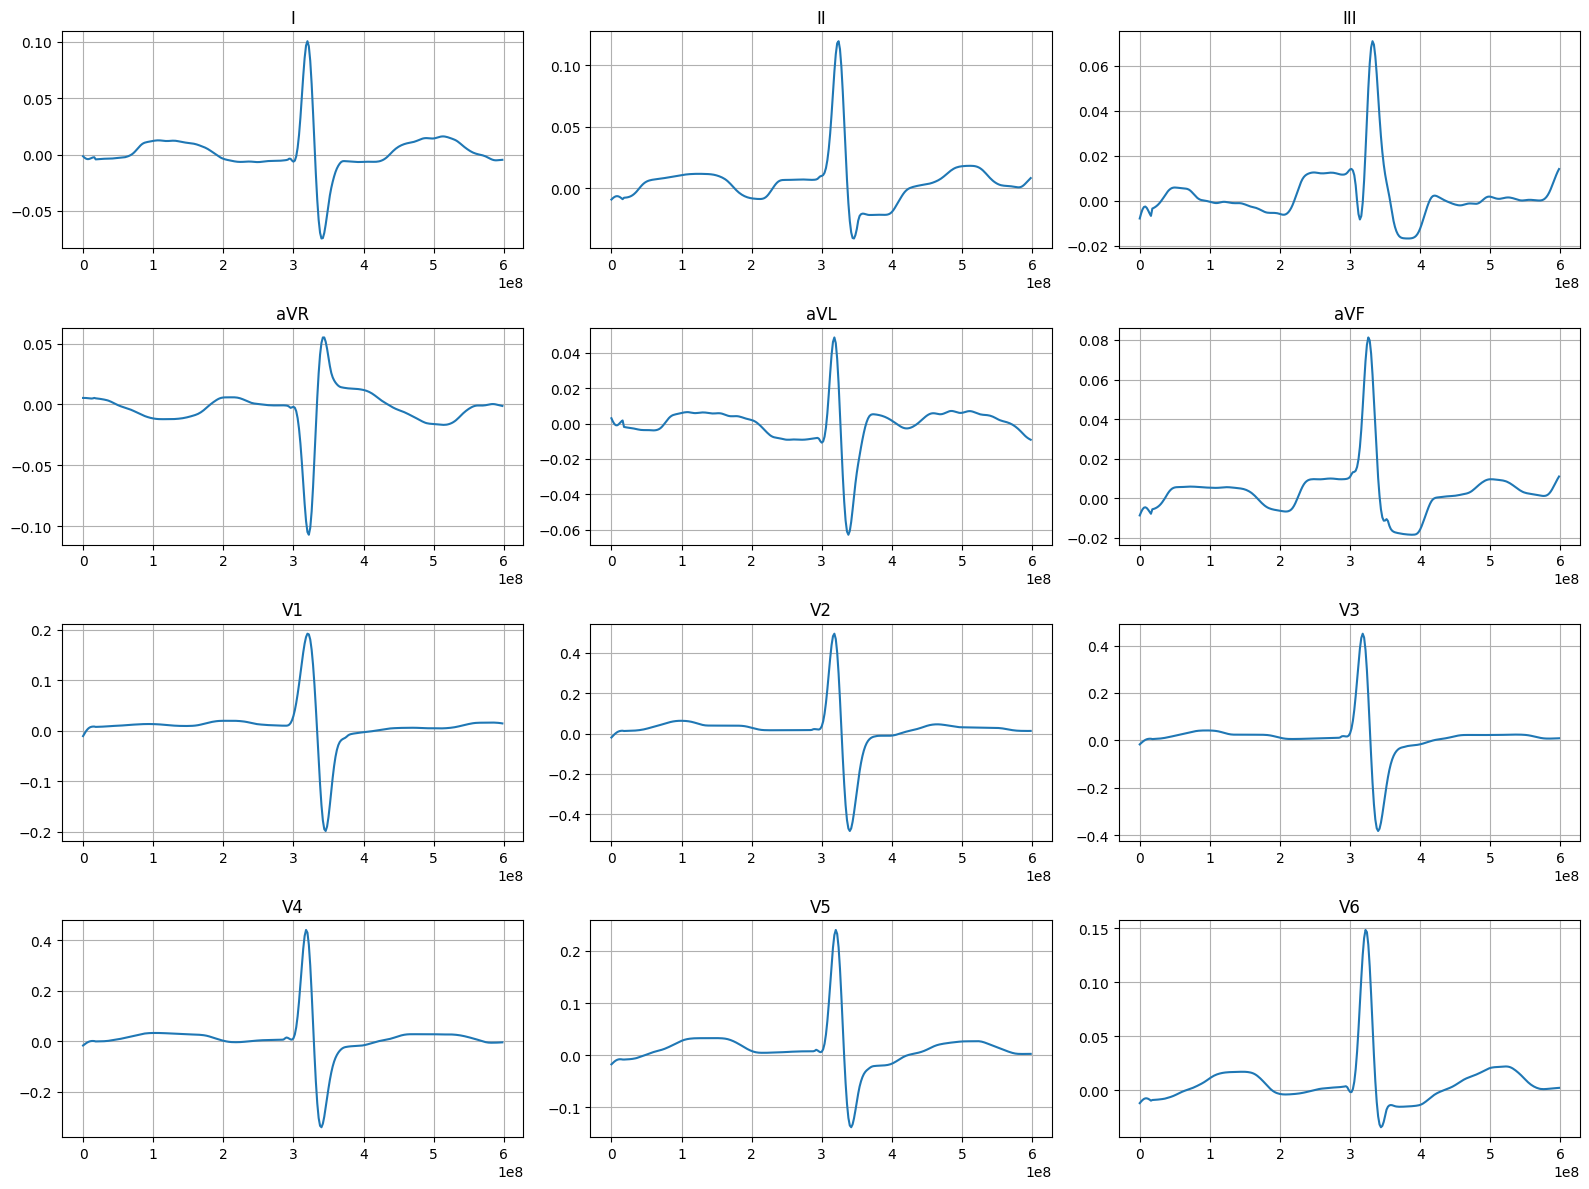

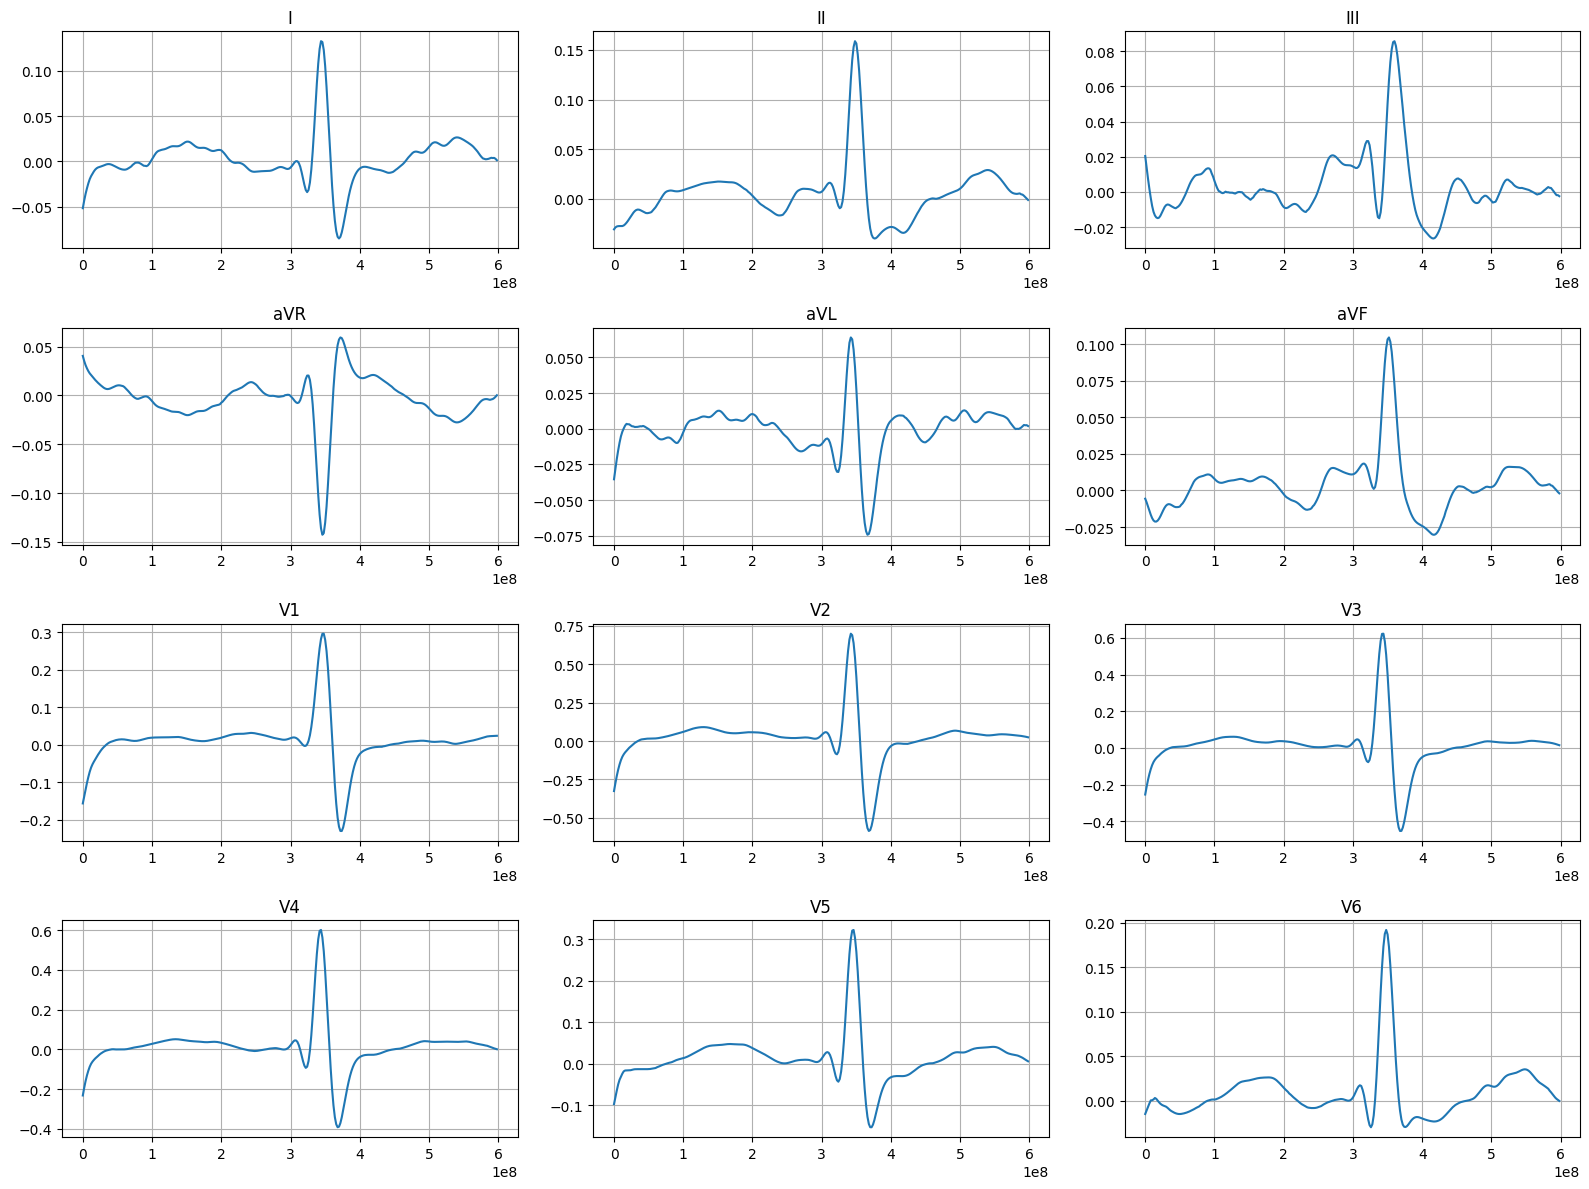

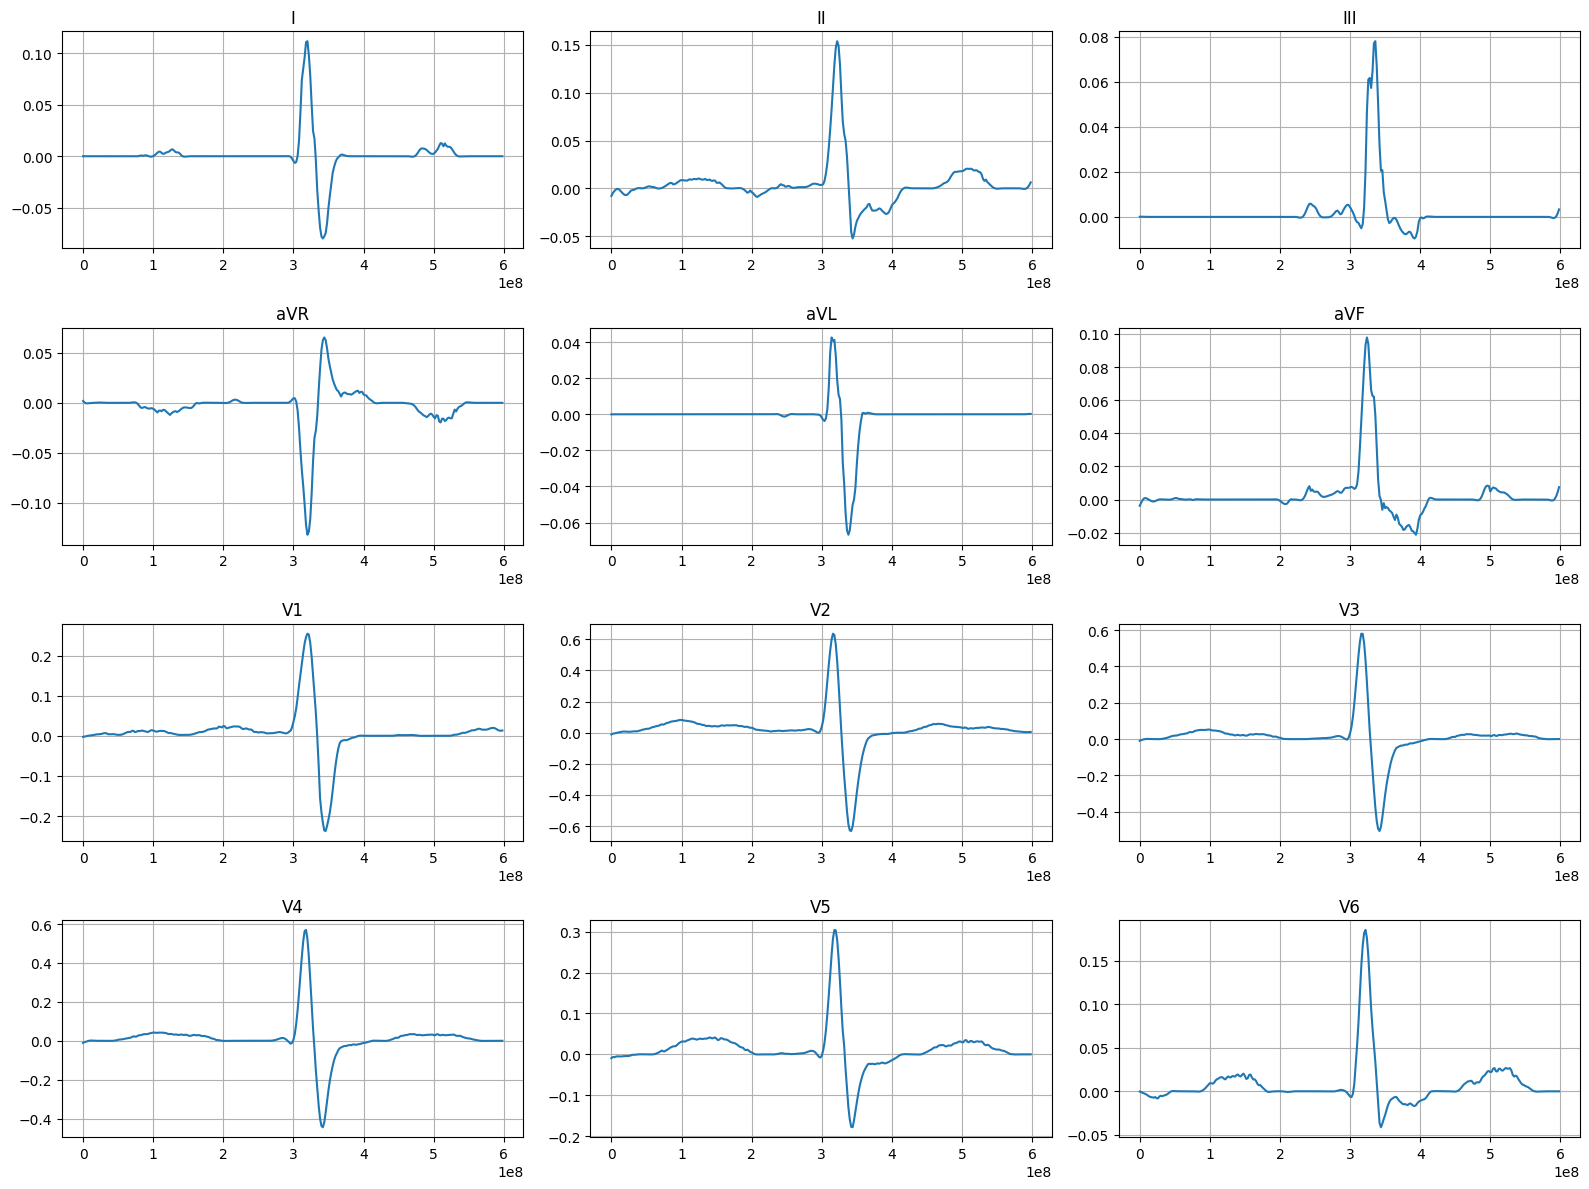

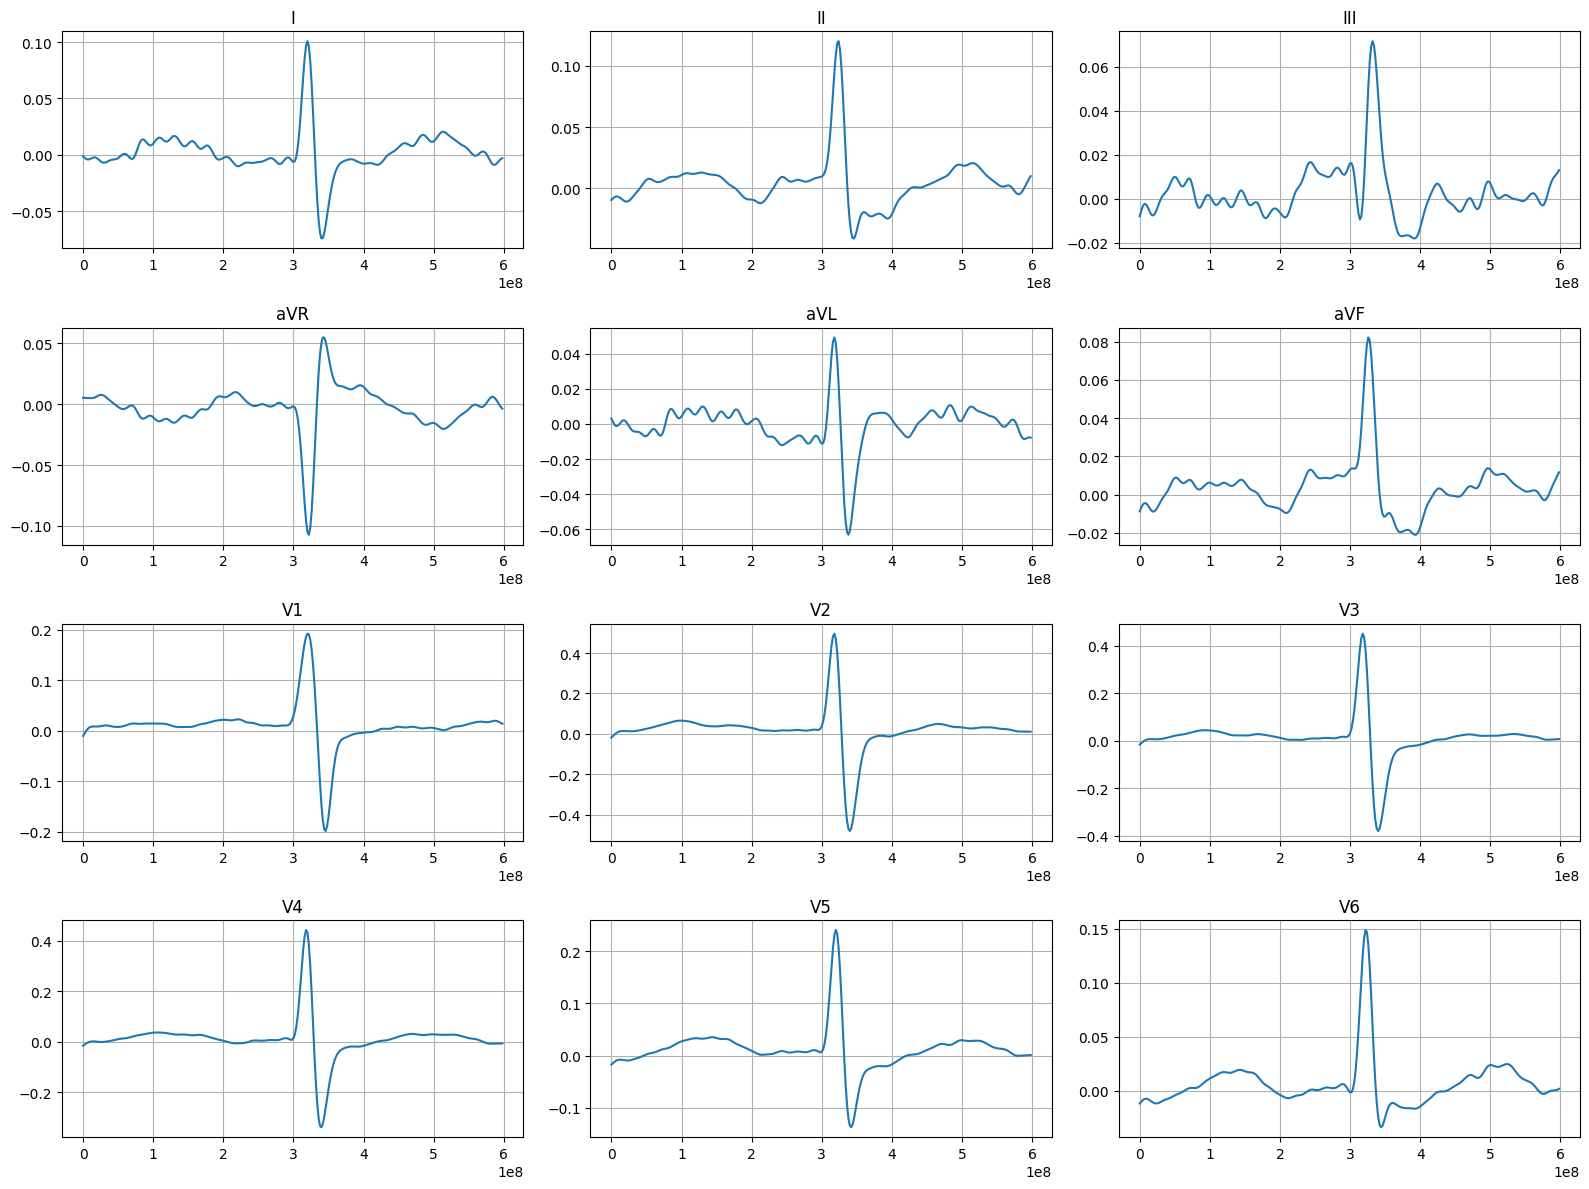

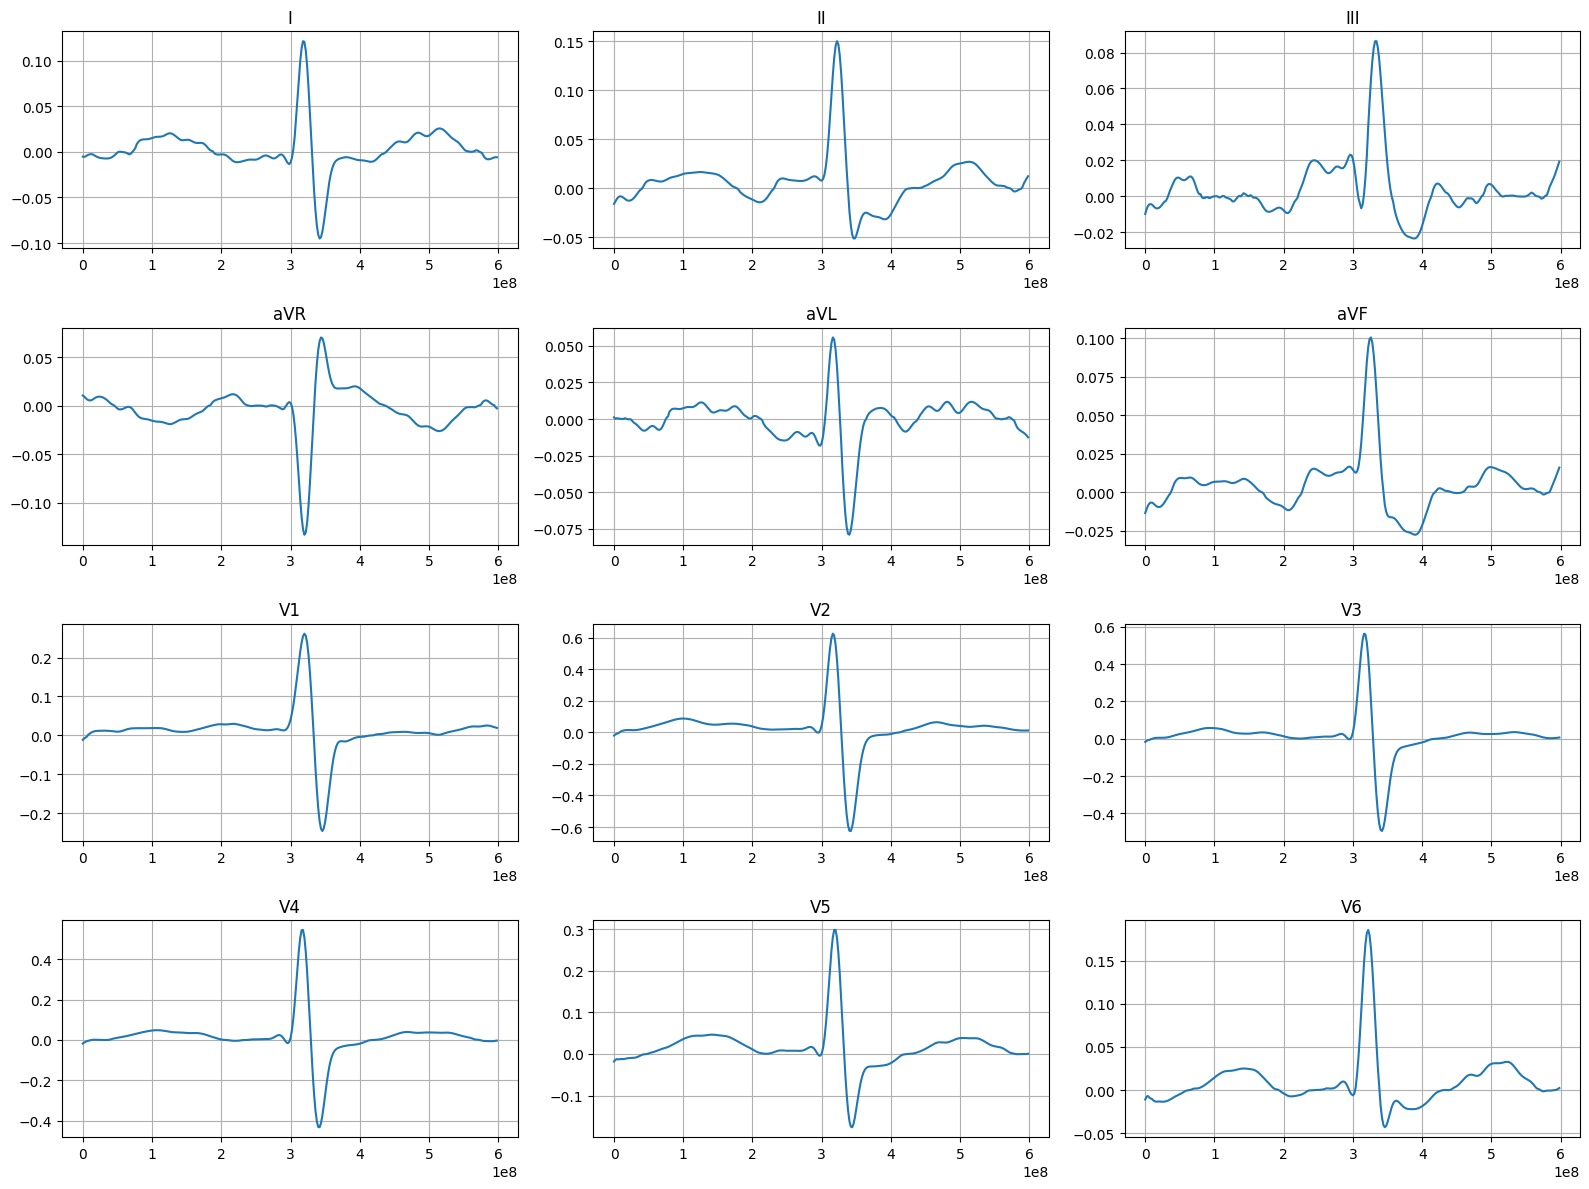

In [94]:
plotLeads(unProcessed,big=True)
plotLeads(signal3_1 ,big=True)
plotLeads(signal3_2 ,big=True)
plotLeads(signal3_3, big=True)
plotLeads(signal3_4, big=True)
plotLeads(signal3_5, big=True)
plotLeads(signal3_6, big=True)
plotLeads(signal3_7, big=True)

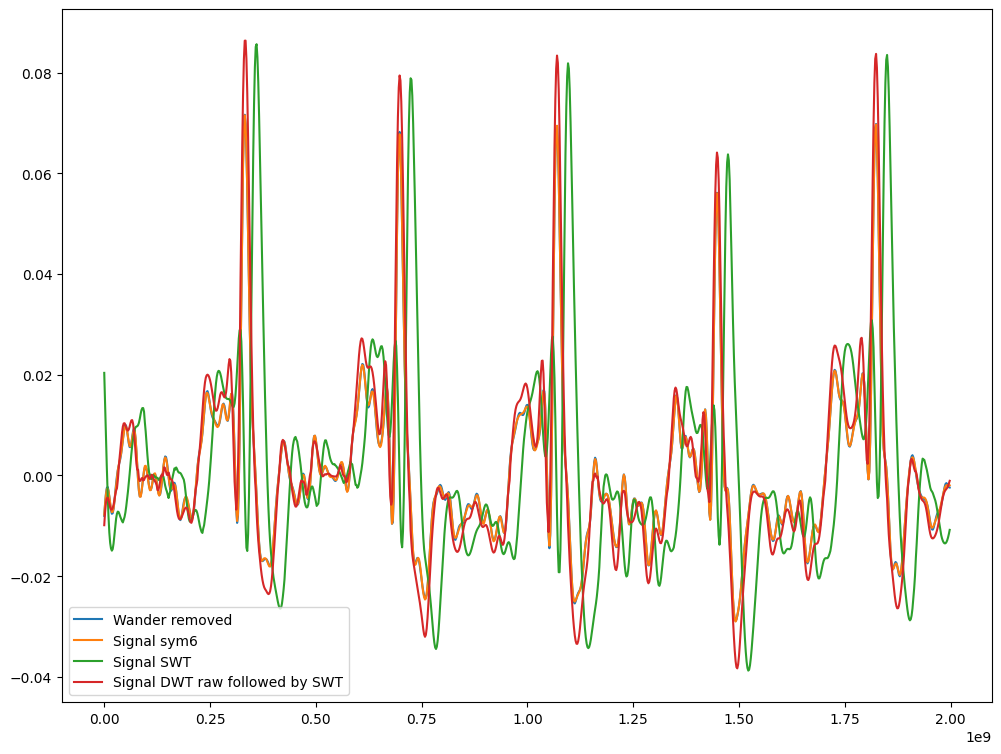

In [101]:
plt.figure(figsize=(12,9))

plt.plot(signal2_1['III'][:1000], label='Wander removed')
# plt.plot(signal3_1['II'][:300], label='Signal db6')
plt.plot(signal3_2['III'][:1000], label='Signal sym6')
# plt.plot(signal3_3['II'][:300], label='Signal NLM')
plt.plot(signal3_4['III'][:1000], label='Signal SWT')
# # plt.plot(signal3_5['I'][:300], label='Signal sym6 raw')
# # plt.plot(signal3_6['I'][:300], label='Signal swt raw')
plt.plot(signal3_7['III'][:1000], label='Signal DWT raw followed by SWT')
plt.legend()
plt.show()

In [96]:
from wfdb.io import wrsamp

array([[-0.00523401, -0.01609998, -0.00987398, ..., -0.01807289,
        -0.01799111, -0.0110236 ],
       [-0.00555955, -0.01371526, -0.00726435, ..., -0.01294502,
        -0.01389517, -0.0076921 ],
       [-0.00498988, -0.01122017, -0.00540216, ..., -0.00884612,
        -0.01233843, -0.00692948],
       ...,
       [-0.00608314, -0.02208483, -0.01518932, ..., -0.03208789,
        -0.01306638, -0.00196702],
       [-0.00553303, -0.02033084, -0.01400528, ..., -0.02846197,
        -0.01514717, -0.00406546],
       [-0.00508432, -0.01823721, -0.01224767, ..., -0.02366247,
        -0.01825979, -0.00732094]])

In [99]:

wrsamp('Test',sf,sig_name=records[0].sig_name,p_signal=signal3_7.to_numpy(),comments=records[0].comments,units=records[0].units)

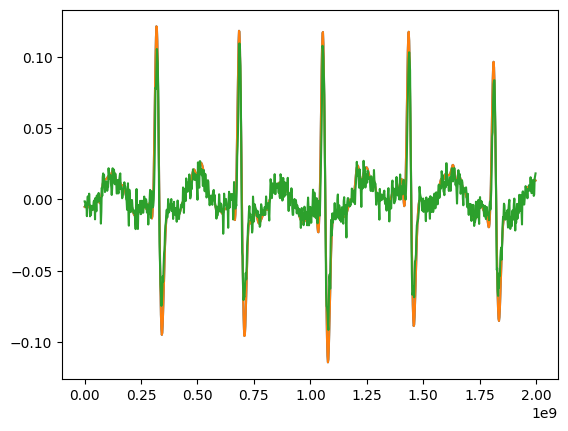

In [106]:
a:Record=rdrecord('test')
a=a.to_dataframe()
plt.plot(a['I'][:1000])
plt.plot(signal3_7['I'][:1000])
plt.plot(rbwSignal['I'][:1000])
